# Error Visualization
This notebook categorizes the errors encountered when running the AutoML benchmark creates visualizations that show when, where, and why errors happen.


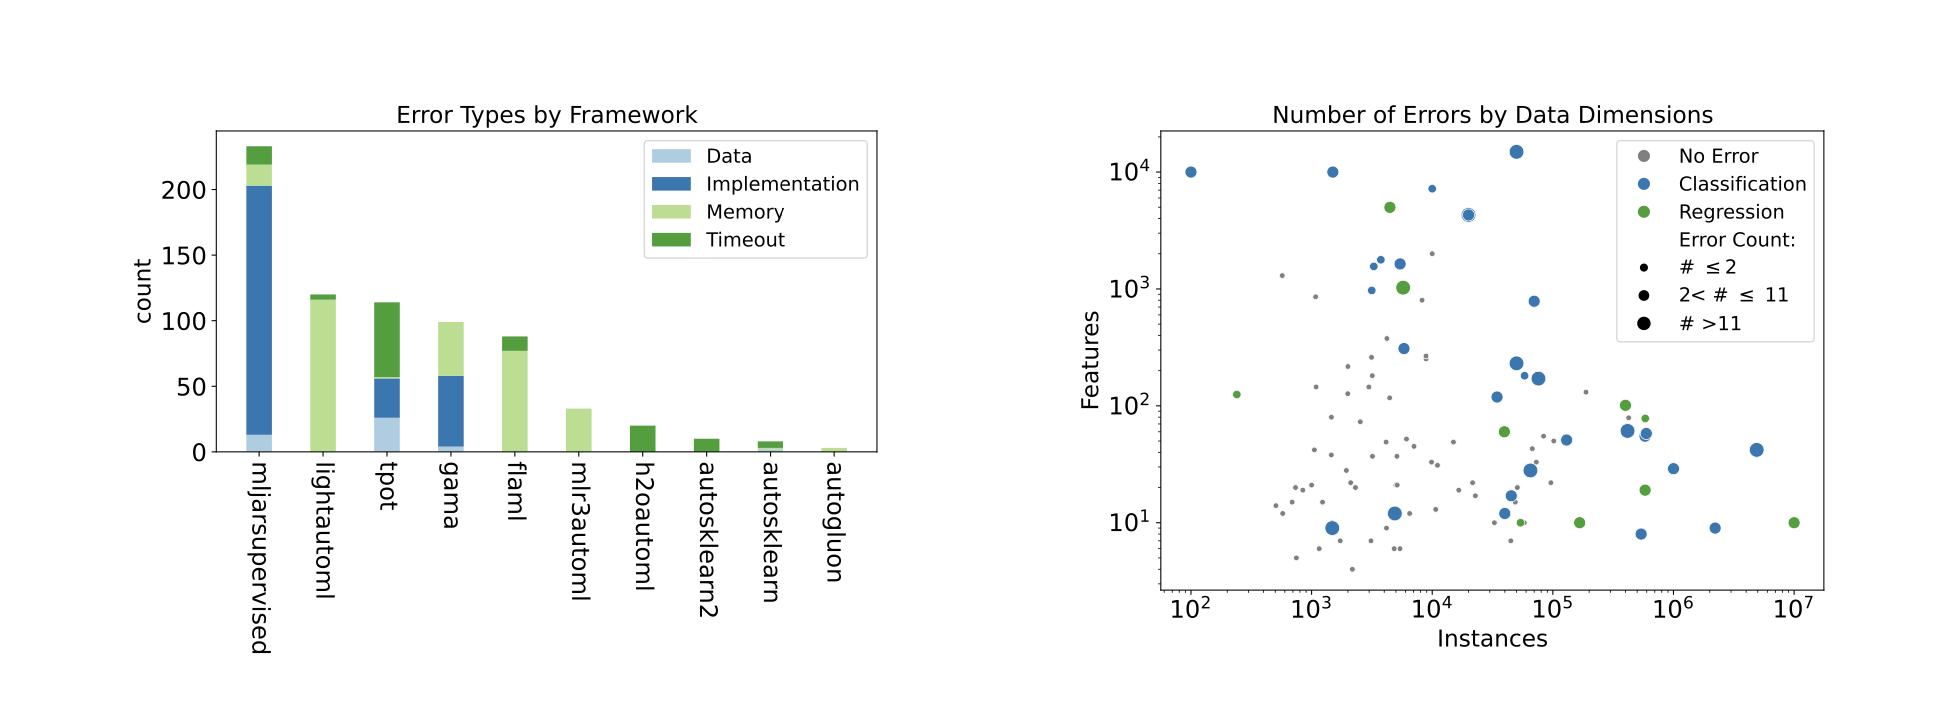

### Loading Data

In [1]:
import itertools
from pathlib import Path
import re

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import seaborn as sns

from data_processing import get_print_friendly_name

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "errors"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results["framework"] = results["framework"].apply(get_print_friendly_name)
results = results[results["framework"] != "NaiveAutoML"]

## Categorizing Errors

In [169]:
with_errors = results[~results["info"].isna()][["framework", "task", "fold", "constraint", "info", "metric", "duration"]]

In [170]:
TIMEOUT_PATTERN = re.compile("Interrupting thread MainThread \[ident=\d+\] after \d+s timeout.")
def is_timeout(message: str) -> bool:
    if re.search(TIMEOUT_PATTERN, message):
        return True
    return False

In [171]:
def is_memory(message: str) -> bool:
    if "Cannot allocate memory" in message:
        return True
    if "exit status 134" in message:
        return True
    if "exit status 137" in message:
        return True
    if "exit status 139" in message:
        return True
    if "exit status 143" in message:
        return True
    if "std::bad_alloc" in message:
        return True
    if "Dummy prediction failed with run state StatusType.MEMOUT" in message:
        return True  # autosklearn
    if "This could be caused by a segmentation fault while calling the function or by an excessive memory usage" in message:
        return True  # lightautoml
    if "OutOfMemoryError: GC overhead limit exceeded" in message:
        return True  # H2O
    return False

In [172]:
def is_data(message: str) -> bool:
    if "NoResultError: y_true and y_pred contain different number of classes" in message:
        return True
    if "The least populated class in y has only 1 member, which is too few." in message:
        return True  # GAMA
    return False

In [173]:
def is_implementation(message: str) -> bool:
    if "Unsupported metric `auc` for regression problems" in message:
        return True  # FLAML produces NaN predictions
    if "A pipeline has not yet been optimized. Please call fit() first." in message:
        return True  # TPOT
    if message == "NoResultError: probability estimates are not available for loss='hinge'":
        return True  # TPOT
    if  "object has no attribute 'predict_proba'" in message:
        return True  # TPOT
    if "'NoneType' object is not iterable" in message:
        return True  # GAMA
    if message == "NoResultError: ":
        return True  # GAMA
    if "Ran out of input" in message:
        return True  # GAMA
    if "Python int too large to convert to C ssize_t" in message:
        return True  # GAMA
    if "invalid load key, " in message:
        return True  # GAMA
    if "Pipeline finished with 0 models for some reason." in message:
        return True  # Light AutoML
    if "No models produced. \nPlease check your data or submit" in message:
        return True  # MLJar
    if "Object of type float32 is not JSON serializable" in message:
        return True  # MLJar
    if "The feature names should match those that were passed during fit" in message:
        return True  # MLJar
    if re.search("At position \d+ should be feature with name", message):
        return True  # MLJar
    if "Ensemble_prediction_0_for_" in message:
        return True  # MLJar
    if "NeuralNetFastAI_BAG_L1'" in message:
        return True  # AutoGluon
    if "No learner was chosen in the initial phase." in message:
        return True  # NaiveAutoML
    return False

In [174]:
def needs_investigation(message: str) -> bool:
    return False

In [175]:
def confirmed_fixed(message: str) -> bool:
    if "'NoneType' object has no attribute 'name'" in message:
        return True  # bug with infer_limit set in 0.8.0, fixed in 0.8.3.
    return False

In [176]:
def needs_rerun(message: str) -> bool:
    if "NoResultError: 'e'" in message:
        return True  # Autosklearn artifact save bug
    if "Auto-sklearn does not yet support sparse pandas Series" in message:
        return True  # Autosklearn
    if re.search("Exception: File: /input/org/openml/www/datasets/\d+/dataset_\d+.pq", message):
        return True
    return False

In [177]:
checks = dict(
    timeout=is_timeout,
    memory=is_memory,
    data=is_data,
    implementation=is_implementation,
    fixed=confirmed_fixed,
    rerun=needs_rerun,
    investigate=needs_investigation,
)

def classify_error(message: str):
    for type_, check in checks.items():
        if check(message):
            return type_
    return "unknown"

In [178]:
with_errors["error_type"] = with_errors["info"].apply(classify_error)

#### Expand the above check functions until no unknown errors are left below

In [179]:
if n_errors:= len(with_errors[with_errors["error_type"] == "unknown"]["info"].unique()):
    print(n_errors)
    print(with_errors[with_errors["error_type"] == "unknown"].iloc[0])
    print(with_errors[with_errors["error_type"] == "unknown"].iloc[0]["info"])

#### Run below to find runs to redo

In [180]:
results.loc[with_errors[(with_errors["error_type"] == "rerun" )].index]

,id,task,framework,constraint,fold,type,result,metric,mode,version,...,mae,r2,rmse,source,infer_batch_size_df_1,infer_batch_size_file_1,infer_batch_size_file_10,infer_batch_size_file_100,infer_batch_size_file_1000,infer_batch_size_file_10000


## Visualizing Errors by Framework

In [181]:
error_counts = with_errors.groupby(["framework", "error_type"], as_index=False).count()    

In [182]:
frameworks = list(with_errors.groupby("framework").count().task.sort_values(ascending=False).index)
error_types = error_counts["error_type"].unique()

In [183]:
all_combinations = pd.DataFrame(itertools.product(error_types, frameworks), columns=["error_type", "framework"])
error_counts = pd.concat([error_counts, all_combinations]).drop_duplicates(subset=["error_type", "framework"], keep='first')
error_counts = error_counts.fillna(0)

In [184]:
color_by_error_type = {
    "data": "#a6cee3",  #light blue
    "implementation": "#2078b4", # dark blue
    "memory": "#A7CE85", #light green
    "timeout": "#32a02d",  #dark green
    "rerun": "#999999",
    "investigate": "#cccccc",
    "fixed": "#fe9900",
}
assert all(error in color_by_error_type for error in error_types)
color_by_error_type = {k: v for k, v in color_by_error_type.items() if k in error_types}

In [185]:
errors_by_framework = {
    error_type: [
        error_counts[(error_counts["error_type"] == error_type) & (error_counts["framework"] == framework)]["info"].iloc[0]
        for framework in frameworks
    ]
    for error_type in color_by_error_type
}

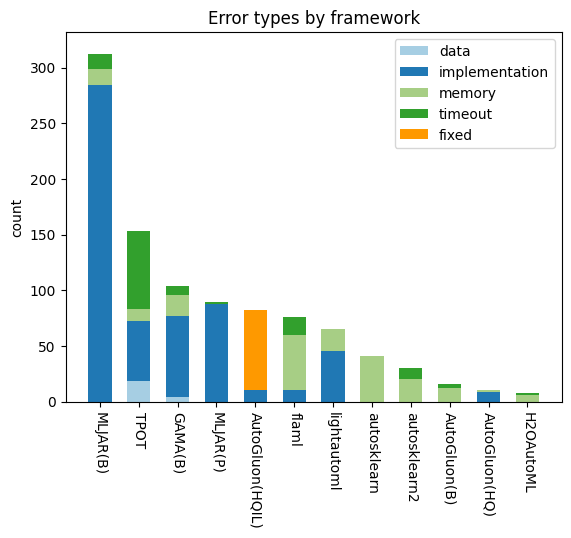

In [186]:
fig, ax = plt.subplots()

bottoms = np.zeros(len(frameworks))
for error_type, counts in errors_by_framework.items():
    ax.bar(frameworks, counts, label=error_type, bottom=bottoms, width=.6, color=color_by_error_type[error_type])
    bottoms += counts

ax.set_ylim([0, max(bottoms) + 20])
ax.set_ylabel("count")
ax.tick_params(axis="x", which="major", rotation=-90)
ax.legend(loc="upper right")
ax.set_title("Error types by framework")

with PdfPages(FIGURE_DIRECTORY / f"errors-by-type-1h8c_gp3.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

## Visualizing Errors by Dataset Size

In [187]:
errors_by_task = with_errors[~with_errors["error_type"].isin(["investigate","implementation"])].groupby("task").count()["info"]

In [188]:
metadata_path = DATA_DIRECTORY / "metadata.csv"
if metadata_path.is_file():
    metadata = pd.read_csv(metadata_path)
else:
    import openml
    regression = openml.study.get_suite(269)
    classification = openml.study.get_suite(271)
    metadata = openml.datasets.list_datasets(data_id=regression.data+classification.data, output_format="dataframe")
    metadata.to_csv(metadata_path, index=False)

In [189]:
all_results = metadata.set_index("name").join(errors_by_task)
all_results = all_results.fillna(0)
all_results = all_results.rename(columns=dict(info="count"))
errors = all_results[all_results["count"]>0].copy()
no_errors = all_results[all_results["count"]==0].copy()

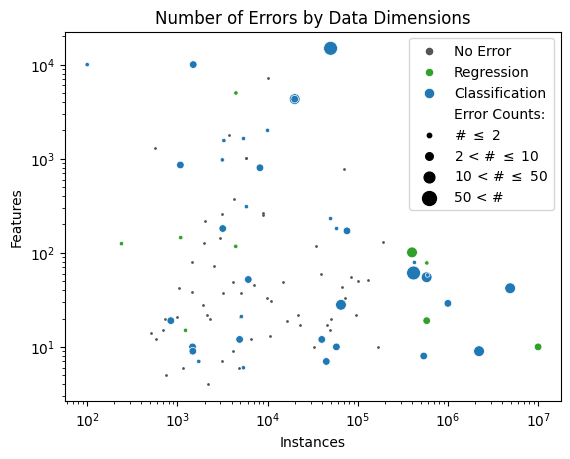

In [190]:
fig, ax = plt.subplots()

errors["marker_size"] = errors["count"].apply(lambda c: 10 if c<3 else (30 if c < 11 else (60 if c<51 else 100)))
classification = errors[errors["NumberOfClasses"] > 0]
regression = errors[errors["NumberOfClasses"] == 0]

ax.scatter(no_errors["NumberOfInstances"], no_errors["NumberOfFeatures"], color="#555555", s=1, label="No Error")
ax.scatter(regression["NumberOfInstances"], regression["NumberOfFeatures"], color="#32a02d", s=regression["marker_size"], label="Regression", edgecolors="white", linewidths=.5)
ax.scatter(classification["NumberOfInstances"], classification["NumberOfFeatures"], color="#2078b4", s=classification["marker_size"], label="Classification", edgecolors="white", linewidths=.5)

ax.scatter(0, 0, color="#ffffff", s=60, label="Error Counts:")
ax.scatter(0, 0, color="#000000", s=10, label="# $\leq$ 2")
ax.scatter(0, 0, color="#000000", s=30, label="2 < # $\leq$ 10")
ax.scatter(0, 0, color="#000000", s=60, label="10 < # $\leq$ 50")
ax.scatter(0, 0, color="#000000", s=100, label="50 < #")

ax.set_xscale("log")
ax.set_xlabel("Instances")
ax.set_yscale("log")
ax.set_ylabel("Features")
ax.set_title("Number of Errors by Data Dimensions")

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legend_handles[0]._sizes = [20]
plt.show()


with PdfPages(FIGURE_DIRECTORY / f"errors-by-data-1h8c_gp3.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

# Comparison of 1h and 4h results
When we are comparing one hour to four hour results, we restrict our analysis to only those frameworks which have had a June 2023 evaluation for both time constraints:

In [206]:
from data_processing import is_old

In [207]:
errors_on_recent = with_errors[~with_errors.apply(lambda r: is_old(r["framework"], "4h8c_gp3", r["metric"]), axis=1)].copy()

For these figures, we simply consider the AutoGluon "fixed" error as an "implementation" error:

In [208]:
errors_on_recent["error_type"] = errors_on_recent["error_type"].apply(lambda err: "implementation" if err == "fixed" else err)



Do errors happen more or less frequently in one hour or four hour results? Which errors?

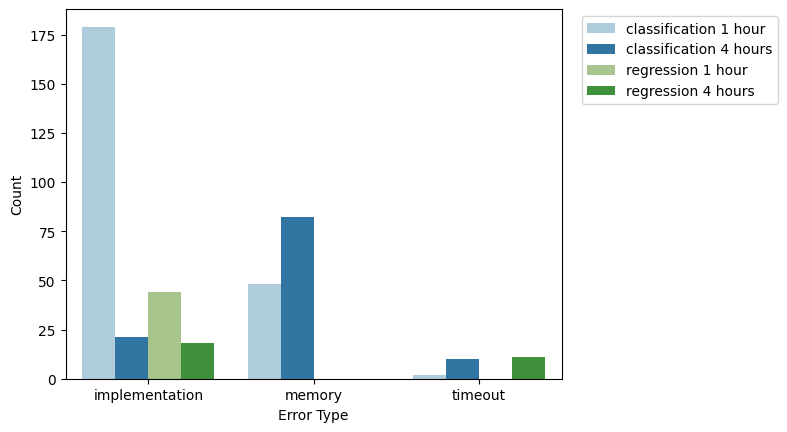

In [237]:
fig, ax = plt.subplots()

suite = {"neg_rmse": "regression", "auc": "classification", "neg_logloss": "classification"}

errors_on_recent["constraint-formatted"] = errors_on_recent["constraint"].apply(lambda s: "1 hour" if s == "1h8c_gp3" else "4 hours")
errors_on_recent["suite-and-constraint"] = errors_on_recent.apply(lambda r: suite[r["metric"]] + " " + r["constraint-formatted"] , axis=1)
errors_by_type_and_constraint = errors_on_recent.groupby(["suite-and-constraint", "error_type"], as_index=False).count()

errors_by_type_and_constraint = errors_by_type_and_constraint.rename(columns={"error_type": "Error Type", "constraint": "Time constraint", "info": "Count"})
errors_by_type_and_constraint = errors_by_type_and_constraint.drop(columns="metric")

hues = {
    "classification 1 hour": "#a6cee3",
    "classification 4 hours": "#2078b4",
    "regression 1 hour": "#A7CE85",
    "regression 4 hours":"#32a02d",
}

sns.barplot(
    errors_by_type_and_constraint,
    x="Error Type",
    y="Count",
    hue="suite-and-constraint",
    hue_order=hues.keys(),
    palette=hues,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.45, 1))

with PdfPages(FIGURE_DIRECTORY / f"errors-by-constraint.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

In [203]:
with_errors.head()

,framework,task,fold,constraint,info,metric,duration,error_type
1420,TPOT,yeast,0,4h8c_gp3,NoResultError: y_true and y_pred contain diffe...,neg_logloss,168.8,data
1421,TPOT,amazon-commerce-reviews,0,4h8c_gp3,NoResultError: A pipeline has not yet been opt...,neg_logloss,267.9,implementation
1422,TPOT,yeast,1,4h8c_gp3,NoResultError: y_true and y_pred contain diffe...,neg_logloss,336.4,data
1423,GAMA(B),airlines,0,4h8c_gp3,NoResultError: [Errno 12] Cannot allocate memory,auc,886.2,memory
1425,GAMA(B),airlines,1,4h8c_gp3,NoResultError:,auc,3150.2,implementation


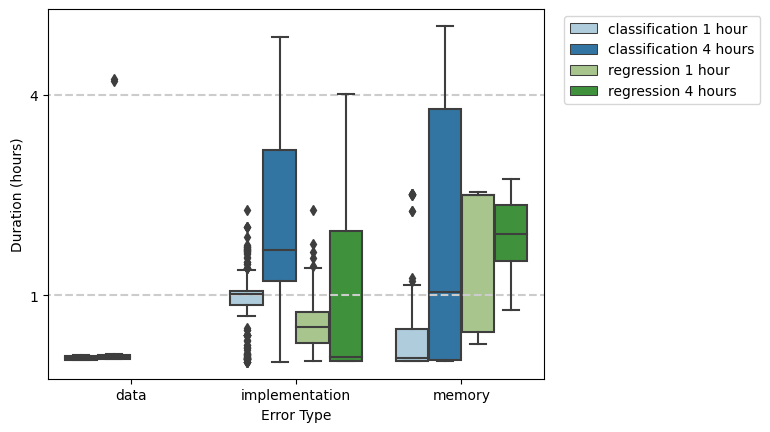

In [241]:
fig, ax = plt.subplots()

errors = with_errors.copy()
errors["error_type"] = errors["error_type"].apply(lambda err: "implementation" if err == "fixed" else err)
error_duration = errors[errors["error_type"].isin(["data", "implementation", "memory"])].copy()
suite = {"neg_rmse": "regression", "auc": "classification", "neg_logloss": "classification"}

error_duration["constraint-formatted"] = error_duration["constraint"].apply(lambda s: "1 hour" if s == "1h8c_gp3" else "4 hours")
error_duration["suite-and-constraint"] = error_duration.apply(lambda r: suite[r["metric"]] + " " + r["constraint-formatted"] , axis=1)
error_duration = error_duration.rename(columns={"error_type": "Error Type", "constraint": "Time constraint", "info": "Count", "duration": "Duration (hours)"})
# errors_by_type_and_constraint = errors_by_type_and_constraint.drop(columns="metric")

hues = {
    "classification 1 hour": "#a6cee3",
    "classification 4 hours": "#2078b4",
    "regression 1 hour": "#A7CE85",
    "regression 4 hours":"#32a02d",
}

ax.plot([-1,4],[3600, 3600], color='#cccccc', linestyle='--')
ax.plot([-1,4],[3600*4, 3600*4], color='#cccccc', linestyle='--')
ax = sns.boxplot(
    error_duration,
    x="Error Type",
    y="Duration (hours)",
    hue="suite-and-constraint",
    hue_order=hues.keys(),
    palette=hues,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
ax.set_yticks([3600, 3600*4], ["1", "4"])
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.45, 1))

with PdfPages(FIGURE_DIRECTORY / f"errors-and-duration.pdf") as f:
    f.savefig(fig, bbox_inches="tight")

### MLJar error count
MLJAR(B) exhibits by far the most "implementation errors". In our 2022 paper, these mostly came from the same error messages.
Is this still the case? How large of a portion is caused by one or two bugs only?

In [243]:
mljar_implementation = with_errors[(with_errors["framework"] == "MLJAR(B)") & (with_errors["error_type"] == "implementation")]

Executing the code below (after uncommenting) reveals mostly the same errors:

In [252]:
# mljar_implementation["info"].unique()

In [259]:
import re
same_features = re.compile(r"The feature names should match those that were passed during fit")
catboost_features = re.compile(r"catboost/libs/data/model_dataset_compatibility.cpp:81: At position")
serialization = re.compile(r"NoResultError: Object of type float32 is not JSON serializable")
predictions = re.compile(r"\[\'Ensemble_prediction_")

In [265]:
for pattern in [same_features, catboost_features, serialization, predictions]:
    count = sum(1 for error_message in mljar_implementation["info"] if re.search(pattern, error_message))
    print(pattern.pattern, "found:", count)

The feature names should match those that were passed during fit found: 82
catboost/libs/data/model_dataset_compatibility.cpp:81: At position found: 149
NoResultError: Object of type float32 is not JSON serializable found: 28
\[\'Ensemble_prediction_ found: 25


In [266]:
len(mljar_implementation)

284

We see that still, the vast majority of issues arise from what seems to be incorrect handling of the data which ultimately leads to a misaligment of the (number of) features.
Whether that's actually the root cause requires investigation into MLJar, which is outside the scope of our work.

In [275]:
mljarp_implementation = with_errors[(with_errors["framework"] == "lightautoml") & (with_errors["error_type"] == "implementation")]
mljarp_implementation

,framework,task,fold,constraint,info,metric,duration,error_type
7685,lightautoml,yeast,0,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,14.3,implementation
7691,lightautoml,KDDCup99,0,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,1468.3,implementation
7708,lightautoml,yeast,1,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,13.0,implementation
7709,lightautoml,yeast,2,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,13.6,implementation
7710,lightautoml,yeast,3,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,13.5,implementation
7711,lightautoml,yeast,9,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,14.2,implementation
7721,lightautoml,wine-quality-white,4,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,946.6,implementation
7722,lightautoml,wine-quality-white,7,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,1747.4,implementation
7723,lightautoml,wine-quality-white,3,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,152.7,implementation
7724,lightautoml,wine-quality-white,6,1h8c_gp3,NoResultError: Pipeline finished with 0 models...,neg_logloss,149.3,implementation


In [273]:
with_errors["framework"].unique()

array(['TPOT', 'GAMA(B)', 'autosklearn2', 'MLJAR(B)', 'flaml',
       'autosklearn', 'lightautoml', 'MLJAR(P)', 'AutoGluon(HQIL)',
       'AutoGluon(HQ)', 'H2OAutoML', 'AutoGluon(B)'], dtype=object)